# Проект по А-В-тестированию

**Задача** — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Необходимо оценить корректность проведения теста и проанализируйте его результаты.

Чтобы оценить корректность проведения теста:

- удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.

**Целью** работы является оценка результатов А/В-тестирования, при этом необходимо обозначить возможность их применения и при возможности выдвинуть рекомендации.

# Итоги исследования

**Была нарушена процедура применения А/В-тестирования:**

данные не соответствуют ТЗ (в дате проведения, количестве участников, наличии смежных акций и тестов, влияющих на пользователей, не все пользователи из необходимого региона);

пользователи за неделю выполняют практически все действия, необходимость проведения теста 14 дней отсутствует при данных показателях (которые могут быть искажены из-за преждевременного окончания сбора данных по событиям);

z-тест показал, что значимая разница между долями присутствует только в событии product_page.


**Вывод при имеющихся данных:**

анализ воронки показал, что группа А имеет лучшие метрики, чем группа В. При этом совершение покупки в группе А происходит на 4% больше, чем в группе В;

**Рекомендуется провести повторное А/В-тестирование**

## Техническое задание

Название теста: recommender_system_test;

Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Аудитория: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемое количество участников теста: 6000.

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart 
- покупки — purchase.

Загрузить данные теста, проверить корректность его проведения и проанализировать полученные результаты.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import math as mth
from scipy import stats as st

In [2]:
path_m = 'https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv'
path_u = 'https://code.s3.yandex.net/datasets/final_ab_new_users.csv'
path_e = 'https://code.s3.yandex.net/datasets/final_ab_events.csv'
path_p = 'https://code.s3.yandex.net/datasets/final_ab_participants.csv'

/datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;

Структура файла:
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

/datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Структура файла:
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

/datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

/datasets/final_ab_participants.csv — таблица участников тестов.

Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

In [3]:
marketing_events = pd.read_csv(path_m)
marketing_events['start_dt'] =pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] =pd.to_datetime(marketing_events['finish_dt'])
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
new_users = pd.read_csv(path_u)
new_users['first_date'] =pd.to_datetime(new_users['first_date'])
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [5]:
events = pd.read_csv(path_e)
events['event_dt'] =pd.to_datetime(events['event_dt'])
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [6]:
participants = pd.read_csv(path_p)
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


## Подготовка данных

### Анализ типов

In [7]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [8]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [9]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [10]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [12]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [13]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [14]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [15]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

### Анализ пропусков

Пропуски есть в таблице events. Скорее всего, это связано с тем, что не у всех значений заполняется поле details.

In [16]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [17]:
events[events['event_name'] == 'purchase'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62740 entries, 0 to 62739
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     62740 non-null  object        
 1   event_dt    62740 non-null  datetime64[ns]
 2   event_name  62740 non-null  object        
 3   details     62740 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.4+ MB


### Анализ дубликатов

In [18]:
marketing_events[marketing_events.duplicated()]

,name,regions,start_dt,finish_dt


In [19]:
new_users[new_users.duplicated()]

,user_id,first_date,region,device


In [20]:
events[events.duplicated()]

,user_id,event_dt,event_name,details


In [21]:
participants[participants.duplicated()]

,user_id,group,ab_test


### Вывод

Тип данных дат было необходимо привести к верному формату.

Пропуски присутствуют только в таблице events и не требуют заполнения, поскольку присутствуют только в поле details и отвечают его логике.

Дубликаты в данных отсутствуют.

## Исследование

### Проверка соответствия ТЗ

- Дата запуска: 2020-12-07;

- Дата остановки набора новых пользователей: 2020-12-21;

- Дата остановки: 2021-01-04;

In [22]:
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

In [23]:
(
    new_users[new_users['user_id']
    .isin(participants[participants['ab_test'] == 'recommender_system_test']['user_id'])]
    ['first_date']
    .max()
)

Timestamp('2020-12-21 00:00:00')

In [24]:
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

Дата запуска теста соответствует минималной дате. При этом пользователи, набранные до 21.12, не совершают события вплоть до 04.01, завершая все события 30.12.

Стоит также отметить, что по факту набор происходит действительно до 21.12, как и указано в ТЗ.

- Аудитория: 15% новых пользователей из региона EU;

In [25]:
start_date = "2020-12-07"
finish_date = "2020-12-21"
participants_date = participants.merge(new_users)
participants_date = participants_date[participants_date['first_date'] <= finish_date]

round(len(participants_date[(participants_date['ab_test'] == 'recommender_system_test') & (participants_date['region'] == 'EU')]) 
      / len(new_users[(new_users['region'] == 'EU') & (new_users['first_date'] <= finish_date)]) * 100, 2)

15.0

In [26]:
test_users = new_users[new_users['user_id'].isin(participants[participants['ab_test'] == 'recommender_system_test']['user_id'])]

In [27]:
round(len(test_users[test_users['region'] == 'EU']) / len(test_users) * 100, 2)

94.78

В тесте участвует около 15% от всех новых пользователей, при этом около 95% из них из региона EU.

- Ожидаемое количество участников теста: 6000.

In [28]:
len(participants[participants['ab_test'] == 'recommender_system_test'])

6701

In [29]:
specification_participants = 6000
round(len(participants[participants['ab_test'] == 'recommender_system_test']) / specification_participants * 100, 2)

111.68

Всего в рассматриваемом тесте 6701 участник. Это составляет 112% от ожидаемого количества в ТЗ.

### Проверка времени проведения теста

In [30]:
end_date = "2021-01-04"
marketing_events[(marketing_events['start_dt'] >= start_date) & (marketing_events['finish_dt'] <= end_date)]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [31]:
marketing_events[(marketing_events['start_dt'] >= start_date)]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


За рассматриваемый период одна акция полностью попадает в рамки теста, вторая заканчивается после окончания теста, при этом начинается 30.12, то есть в момент, когда фактически пользователи из когорты заканчивают все свои события.

Это могло повлиять на результаты тестирования, поскольку маркетинговая кампания происходила не на протяжении всего теста. Тем не менее, она влияла как на группу А, так и на группу В.

In [32]:
events['event_date'] = events['event_dt'].dt.floor('D')
events = new_users.merge(events, how='left')
events['days'] = events['event_date'] - events['first_date']
events = events[events['days'] < pd.to_timedelta(14, unit='D')] 

Ожидаемый эффект рассматривается за 14 дней с момента регистрации, остальное отсекается.

### Проверка аудитории теста

In [33]:
user_group = participants[participants['ab_test'] == 'recommender_system_test']
user_group.duplicated().sum()

0

В рамках одного теста пользователи не попалают в обе группы А и В. Количество пользователей совпадает с количеством групп пользователь-А/В группа

In [34]:
participants['user_id'].duplicated().sum()

1602

1602 пользователя попали в несколько групп (то есть либо в оба теста, либо в обе группы)

In [35]:
recommender_system_test_A = user_group[user_group['group'] == 'A']
recommender_system_test_B = user_group[user_group['group'] == 'B']

user_group_2 = participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B')]

In [36]:
recommender_system_test_A['user_id'].isin(user_group_2['user_id']).sum()

439

In [37]:
recommender_system_test_B['user_id'].isin(user_group_2['user_id']).sum()

344

В группу А попало 439 пользователей из второго теста, в группу В - 344.

In [38]:
round(
    recommender_system_test_A['user_id'].isin(user_group_2['user_id']).sum()
/  
    user_group[user_group['group'] == 'A'].count() * 100, 2)

user_id    11.48
group      11.48
ab_test    11.48
dtype: float64

In [39]:
round(
    recommender_system_test_B['user_id'].isin(user_group_2['user_id']).sum()
/  
    user_group[user_group['group'] == 'A'].count() * 100, 2)

user_id    9.0
group      9.0
ab_test    9.0
dtype: float64

Количество пользователей из второго тесте в группе А составляет 11,5%, в группе В - 9%. Можно сказать, что влияние происходит довольно равномерно.

In [40]:
user_group['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

При этом всего пользователей в группе А 3824, а пользователей в группе В - 2887.

In [41]:
round(len(user_group[user_group['group'] == 'A']) / len(user_group[user_group['group'] == 'B']) * 100 - 100, 2)

32.92

В рассматриваемом случае пользователей в группе А на примерно 33% больше, чем в группе В.

### Вывод

Нельзя сказать, что данные полностью соответствуют ТЗ:

дата запуска и остановки работы совпадают с ТЗ, дата окончания теста - нет;

во время проведения теста было пересечение с 2 маркетинговыми акциями;

в тесте завлечены (хоть и распределены равномерно) пользователи из конкурирующего теста;

группа А по количеству польователей больше группы В на 33%.

## Воронка

### Анализ распределения событий между пользователями

In [42]:
recommender_system_test_A = recommender_system_test_A.merge(events, how='left')
recommender_system_test_A['user_id'].nunique()

3824

In [43]:
recommender_system_test_B = recommender_system_test_B.merge(events, how='left')
recommender_system_test_B['user_id'].nunique()

2877

Создаются таблицы, в которые ко всем пользователям необходимого теста групп А или В добавляются проделанные события.

In [44]:
events_A = (
    recommender_system_test_A.pivot_table(index='user_id', values='event_name', aggfunc=['count', 'nunique'])
    .reset_index()
)
events_A.columns = ['user_id', 'total_events', 'unique_events']

a_total = events_A['total_events'].sum()
a_mean = events_A['total_events'].mean()
a_median = events_A['total_events'].median()
a_median_unique = events_A['unique_events'].median()

events_B = (
    recommender_system_test_B.pivot_table(index='user_id', values='event_name', aggfunc=['count', 'nunique'])
    .reset_index()
)
events_B.columns = ['user_id', 'total_events', 'unique_events']

b_total = events_B['total_events'].sum()
b_mean = events_B['total_events'].mean()
b_median = events_B['total_events'].median()
b_median_unique = events_B['unique_events'].median()


print(f'Общее количество событий в группе А: {a_total}\n'
     f'Среднее количество событий в группе А: {a_mean:.2f}\n'
     f'Медианное количество событий в группе А: {a_median:.2f}\n'
     f'Общее количество событий в группе B: {b_total}\n'
     f'Среднее количество событий в группе В: {b_mean:.2f}\n'
     f'Медианное количество событий в группе В: {b_median:.2f}\n\n'
     f'Медианное количество уникальных событий на пользователя в группе А: {a_median_unique}\n'
     f'Медианное количество уникальных событий на пользователя в группе B: {b_median_unique}\n'
     f'Отношение количества событий в группе А к группе В в %: {a_total/b_total*100:.2f}')

Общее количество событий в группе А: 18801
Среднее количество событий в группе А: 4.92
Медианное количество событий в группе А: 4.00
Общее количество событий в группе B: 5055
Среднее количество событий в группе В: 1.76
Медианное количество событий в группе В: 0.00

Медианное количество уникальных событий на пользователя в группе А: 2.0
Медианное количество уникальных событий на пользователя в группе B: 0.0
Отношение количества событий в группе А к группе В в %: 371.93


При разнице количества пользователей в примерно 1,3, разница количества событий между группами составляет около 3,7. При этом медианное количество событий в группе В составляет 0 против 4 в группе А.

Среднее количество событий для группы А составляет около 5, в то время как для группы В меньше 2 (1,76).

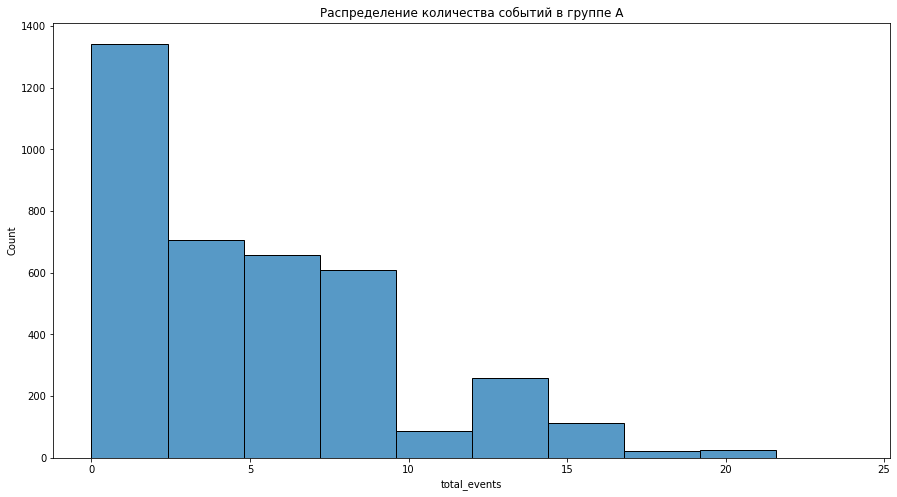

In [45]:
plt.figure(figsize=(15, 8))
sns.histplot(events_A['total_events'], bins=10)
plt.title('Распределение количества событий в группе А')
plt.show()

Больше всего пользователей в группе А совершили от 0 до 2 дейтсвий, далее резкий скачок и плато от 2,5 до примерно 10 действий.

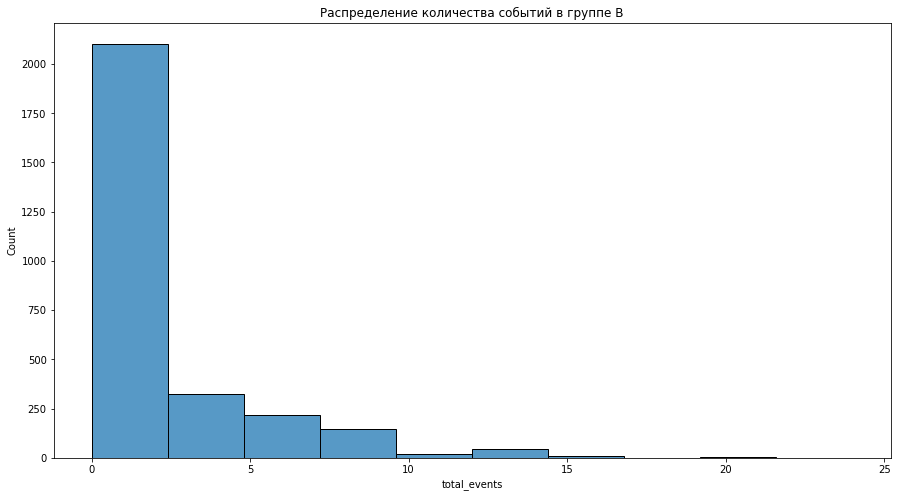

In [46]:
plt.figure(figsize=(15, 8))
sns.histplot(events_B['total_events'], bins=10)
plt.title('Распределение количества событий в группе B')
plt.show()

Скачок в группе В между 0-2 и 2-5 действиями гораздо глубже. Видно, что большинство пользователей из выборки не совершали действий.

### Анализ распределения по дням

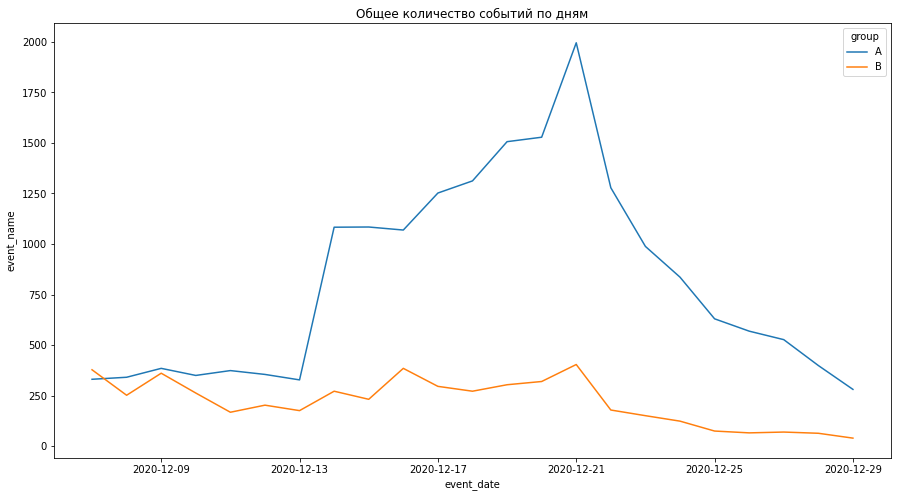

In [47]:
recommender_system_test_A['group'] = 'A'
recommender_system_test_B['group'] = 'B'
test = recommender_system_test_A.append(recommender_system_test_B)
test['event_date'] = test['event_dt'].dt.floor('D')
data_users = test.pivot_table(index=['group','event_date'], values='event_name', aggfunc='count').reset_index()

plt.figure(figsize=(15, 8))
ax = sns.lineplot(y='event_name', x='event_date', hue='group', data=data_users)
plt.title('Общее количество событий по дням')
plt.show()

В группе В достаточно стабильное количество событий по дням, при этом в начале события группы А схожи в количестве с группой В (особенно учитывая разницу в 30% в участниках групп). Далее, с 13 декабря, происходит резкий рост событий в группе А, продолжающийся до 21 декабря, далее - спад в обеих группах (что логично, поскольку с 21 декабря перестает происходить набор в группы).

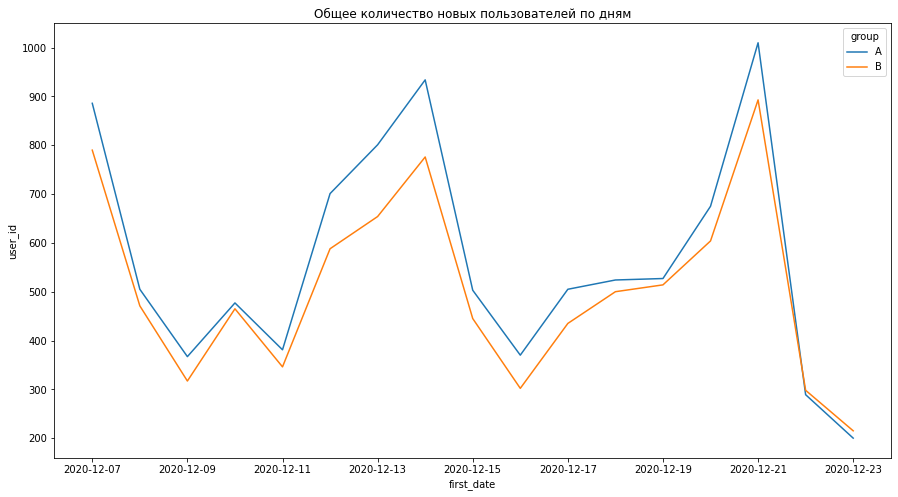

In [48]:
new_users_date = new_users.merge(participants)
new_users_date= new_users_date.pivot_table(index=['group','first_date'], values='user_id', aggfunc='count').reset_index()

plt.figure(figsize=(15, 8))
ax = sns.lineplot(y='user_id', x='first_date', hue='group', data=new_users_date)
plt.title('Общее количество новых пользователей по дням')
plt.show()

Новые пользователи появлялись равномерно в группах А и В, при этом в группе В всегда ниже. Видно, что в период с 12 по 14 происходил рост пользователей с пиком 14 декабря и дальнейшим спадом. Этим можно объяснить повышения количества событий в эти же даты.

### Построение воронки

In [49]:
test = test.merge(new_users)
test['days'] = test['event_date'] - test['first_date']
test = test[test['days'] < pd.to_timedelta(14, unit='D')] #ограничение измерения метрик за 14 дней с момента регистрации

In [50]:
users_A = test[test['group'] == 'A'].groupby('event_name').agg({'user_id': 'nunique'})
users_A['share'] = round(users_A['user_id'] / test[test['group'] == 'A']['user_id'].nunique(), 2)
users_A = users_A.reset_index()
users_A

,event_name,user_id,share
0,login,2747,1.00
1,product_cart,824,0.30
2,product_page,1780,0.65
3,purchase,872,0.32


В группе А из все зашли в систему. При этом на странице продукта оказалось 65%, совершили покупку и добавили в корзину примерно одно количество пользователей - 30% и 32%. Это можно объяснить возможным наличием в магазине "быстрой покупки".

In [51]:
users_B = test[test['group'] == 'B'].groupby('event_name').agg({'user_id': 'nunique'})
users_B['share'] = round(users_B['user_id'] / test[test['group'] == 'B']['user_id'].nunique(), 2)
users_B = users_B.reset_index()
users_B

,event_name,user_id,share
0,login,927,1.00
1,product_cart,255,0.27
2,product_page,523,0.56
3,purchase,256,0.28


В группе В 56% зашли на страницу товара, 28% - совершили покупку.

In [1]:
#funnel_A = users_A[['event_name', 'user_id']]
#index_sorted = [0, 2, 1, 3]
#funnel_A = funnel_A.reindex(index_sorted)

#funnel_B = users_B[['event_name', 'user_id']]
#index_sorted = [0, 2, 1, 3]
#funnel_B = funnel_B.reindex(index_sorted)

#fig = go.Figure()

#fig.add_trace(go.Funnel(
#    name = 'A',
#    y = funnel_A['event_name'],
#    x = funnel_A['user_id'],
#    textinfo = "value+percent initial"))

#fig.add_trace(go.Funnel(
#    name = 'B',
#    y = funnel_B['event_name'],
#    x = funnel_B['user_id'],
#    textinfo = "value+percent initial"))

#fig.update_layout(title_text = 'Воронка конверсии событий по группам A/B')
#fig.show()

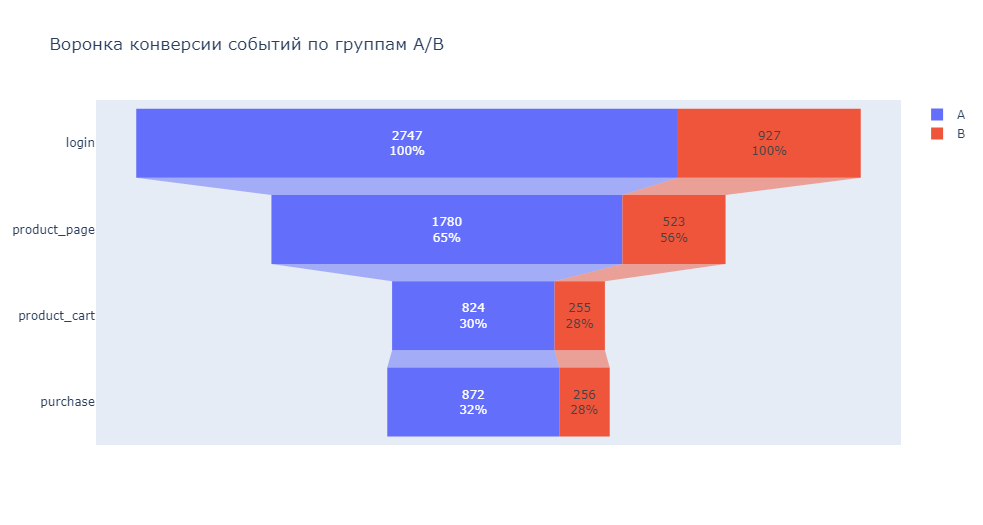

32% пользователей совершили покупку в группе А и 28% в группе В. При этом зашедших в профиль пользователей в группе В практически в 3 раза меньше, чем в группе А.

### Вывод

Приступая к тестированию нужно учесть, что группы А и В собраны довольно различно.

Размеры групп различаются в 1,3 раза, в то время как количество событий на группу А в около 3,5 раза больше. 

Медианное и среднее количество событий по группам различно, в группе В медианное количество событий 0, в группе А - 4.

В воронку попали не все пользователи, поскольку не все пользователи за рассмотренный период совершали событие. На первом шаге воронки в группе А в примерно 3 раза больше пользователей, чем в группе В. При этом на каждом последующем шаге пользователи в группах уменьшались в схожих пропорциях (разница от 3 до 9 %).

## A/B-тест

### Проверка метрик

In [53]:
events_data = test.pivot_table(index=['days', 'group', 'event_name'], values='user_id', aggfunc='nunique').reset_index()

In [54]:
product_page = events_data[events_data['event_name'] == 'product_page']
product_cart = events_data[events_data['event_name'] == 'product_cart']
purchase = events_data[events_data['event_name'] == 'purchase']

In [55]:
pd.options.mode.chained_assignment = None
product_page['events_cumsum'] = product_page.groupby('group')['user_id'].cumsum()
product_cart['events_cumsum'] = product_cart.groupby('group')['user_id'].cumsum()
purchase['events_cumsum'] = purchase.groupby('group')['user_id'].cumsum()

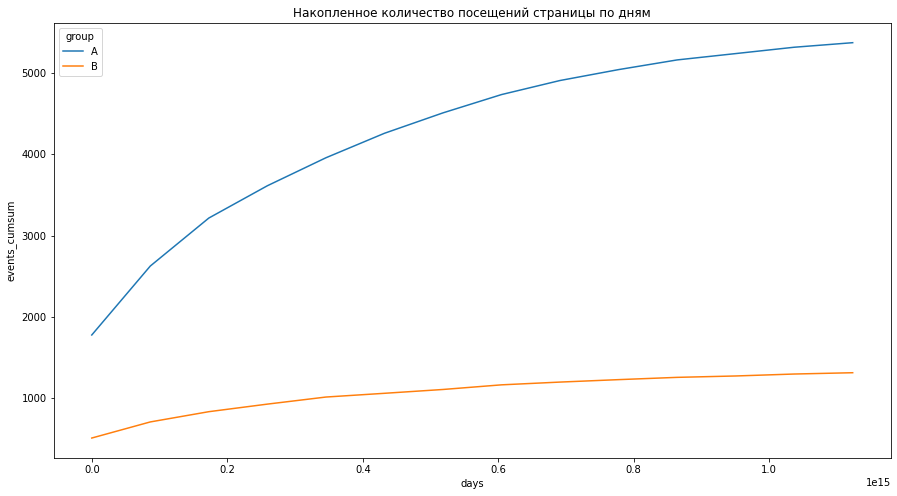

In [56]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(y='events_cumsum', x='days', hue='group', data=product_page)
plt.title('Накопленное количество посещений страницы по дням')
plt.show()

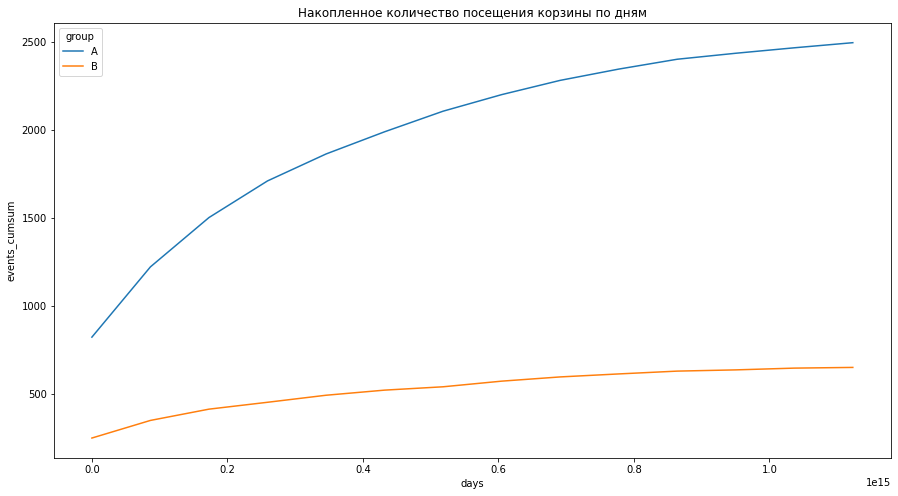

In [57]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(y='events_cumsum', x='days', hue='group', data=product_cart)
plt.title('Накопленное количество посещения корзины по дням')
plt.show()

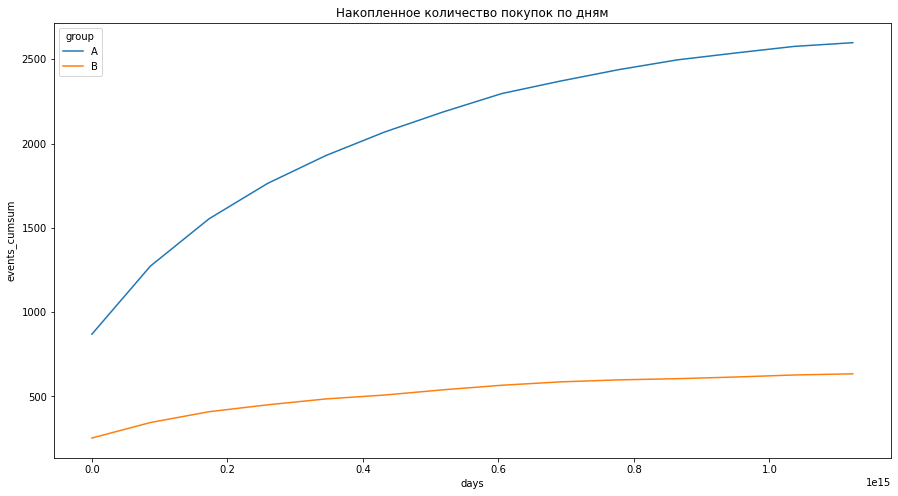

In [58]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(y='events_cumsum', x='days', hue='group', data=purchase)
plt.title('Накопленное количество покупок по дням')
plt.show()

Нельзя сказать, что за 14 дней метрики разительно улучшились. Причиной тому может быть то, что пользователи завершают свои действия гораздо быстрее - уже на 7 день графики становятся достаточно пологими, что говорит о том, что большинство пользователей к этому времени уже завершиили свои действия на сайте. 

В группе В рост менее яркий, чем в группе А.

### A/B-тест, проверка z-критерия

Так же роводится z-тест (проверка гипотезы о равенстве долей). Альфа принимает значение 0,05/3 (с учетом поправки Бонферрони).

**H0:** между групп A и В нет различий в долях

**H1:** между долями есть значимая разница

In [59]:
def test_z(group_1, group_2, event, alpha):
      
    def successes_trials(group1, group2, event):
            successes = (
                np
                .array([test.query(f'group == "{group_1}"  & event_name == "{event}"')['user_id'].nunique(),
                          test.query(f'group == "{group_2}" & event_name == "{event}"')['user_id'].nunique()])
            )
            trials = (
                np
                .array([test.query(f'group == "{group_1}"')['user_id'].nunique(),\
                           test.query(f'group == "{group_2}"')['user_id'].nunique()])
            )
            return successes, trials
        
    successes, trials = successes_trials(group_1, group_2, event) 
# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
# пропорция успехов во второй группе: 
    p2 = successes[1]/trials[1]
    print(trials[0], trials[1])
# пропорция успехов в комбинированном датасете: 
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
 
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
 
    distr = st.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Группы {group_1} и {group_2}. Событие {event}')
 
    print('p-значение: ', round(p_value, 4))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n'
        )

In [60]:
alpha = 0.05 / 3 # критический уровень статистической значимости с поправкой
group_1 = 'A'
group_2 = 'B'

test_z(group_1, group_2, 'product_page', alpha)
test_z(group_1, group_2, 'product_cart', alpha)
test_z(group_1, group_2, 'purchase', alpha)

2747 928
Группы A и B. Событие product_page
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

2747 928
Группы A и B. Событие product_cart
p-значение:  0.1453
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

2747 928
Группы A и B. Событие purchase
p-значение:  0.0176
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Вывод

Группы А и В значительно различаются по количеству пользователей и совершаемых ими событий. При этом необходимость следить за метриками на протяжении 14 дней отсутствует, поскольку большинство событий заканчиваются на 7 день.

Метрики группы А значительно выше, чем в группе В.

Z-тест показал, что значимая разница между долями присутствует только в событии product_page. При этом событие purchase проходит порог в 0,05, но не проходит порог в 0,05/3.

## Выводы

**Была нарушена процедура применения А/В-тестирования:**

данные не соответствуют ТЗ (в дате проведения, количестве участников, наличии смежных акций и тестов, влияющих на пользователей, не все пользователи из необходимого региона);

пользователи за неделю выполняют практически все действия, необходимость проведения теста 14 дней отсутствует при данных показателях (которые могут быть искажены из-за преждевременного окончания сбора данных по событиям);

z-тест показал, что значимая разница между долями присутствует только в событии product_page.


**Вывод при имеющихся данных:**

анализ воронки показал, что группа А имеет лучшие метрики, чем группа В. При этом совершение покупки в группе А происходит на 4% больше, чем в группе В;

**Рекомендуется провести повторное А/В-тестирование**